A first neural network
----------------------
Following http://pytorch.org/tutorials/beginner/pytorch_with_examples.html

A fully-connected ReLU network with 1 hidden layer as example. 
The network will be trained with gradient descent to fit random data 
by minimizing the Euclidean distance between the network output and the true output.
i.e. minimizing quadratic loss $\alpha$


Input:&emsp; &emsp; &emsp;&emsp;  $x = (x_i);\; i=1\dots D_{in}$<br>
2nd layer: $\hspace{0.4em}h=(h_j);\;   j=1\dots H$<br>
Output:&emsp; &emsp; &emsp;  $y=(y_k);\; k=1\dots D_{out}$

Weights:      $W_1=(w^{(1)}_{ij});\;D_{in}\times H$<br>
&emsp; &emsp; &emsp;&emsp;  $W_2=(w^{(2)}_{jk});\;H \times D_{out}$<br>

$h=xW_1$<br>
$\tilde{h_j}=f_{ReLU}(h_j);\;\;f_{ReLU}(h_j)=\max(h_j,0);\;\implies 
\frac{\partial f_{ReLU}(x) }{\partial x}=\{_{0\;if\;x\lt 0}^{1\;if\;x\ge 0}=\theta(x)$<br>
$\hat{y\;}=\tilde{h\;}W_2$

Loss function: $L=(\hat{y}-y)^2$

Backpropagation, i.e. chain rule on loss function:<br>
$\frac{\partial L}{\partial W_1} = 2(\hat{y}-y)\frac{\partial\tilde{h}}{\partial W_1}W_2
= 2(\hat{y}-y)\Theta\frac{\partial h}{\partial W_1}W_2
=  2(\hat{y}-y)\Theta x W_2 
$<br>
$\frac{\partial L}{\partial W_2} = 2(\hat{y}-y)\tilde{h}$

We need some toy data
---------------------

A sine over a parabola in a hundred dimensional space:
 
 $$y=\sin(\sum_{i=1}^{100} x_i^2)$$

The positions $\mathbf{x}$ are randomly picked from $x_i\in\left[-1,1\right]$.

First implementation: pure NumPy as Warm-up
-------------------------------------------
dk bias

A fully-connected ReLU network with two layers and no biases, trained to
predict y from x using Euclidean error.

This implementation uses numpy to manually compute the forward pass, loss, and
backward pass.

A numpy array is a generic n-dimensional array; it does not know anything about
deep learning or gradients or computational graphs, and is just a way to perform
generic numeric computations.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# we need some toy data:
# A parabola in a hundred dimensional space
# 100 dim x_i <- [-1,1] i=0..99
# f(x)=sin(|x|^2)

#1000 data samples
N_samples=1000
N_in=100
#uniform in [0,1)
X=np.random.rand(N_samples,N_in).astype('float32')
# to [-1,1)
X=2*X-1
# x^2
Y=np.sum(np.square(X),axis=1).reshape(N_samples,1).astype('float32')
Y=np.sin(Y)

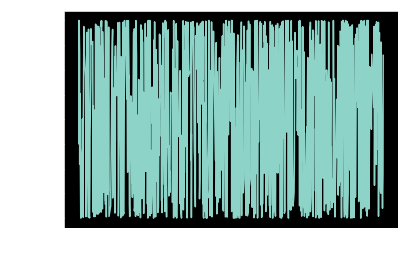

In [3]:
# plot of a 1-dim slice
idx=np.argsort(X[:,0])
plt.plot(X[idx,0],Y[idx])
plt.ylabel(r'$sin(\vec{x}^2$)')
plt.xlabel(r'$x_0$')
plt.show()
# the noisiness comes from the other dimensions and the randomly picked positions in x
# the model itself is fully deterministic y=sin(sum_i (x_i)^2)

In [ ]:
import numpy as np

# N is "batch" size; we use the full data as batch for this example 
# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 100, 10, 1

x=X
y=Y

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

L=[]
learning_rate = 1e-6
n_steps=200
for t in range(n_steps):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    print(t, loss)
    L.append(loss)
    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

# we plot aour learning curve
Xaxis = np.arange(0,n_steps)
#plt.subplot(121)
plt.title('loss eveolution')
plt.plot(Xaxis,L,label='loss')
plt.xlabel('iterations')
plt.ylabel('squared loss')
plt.show()


# Second - PyTorch tensors as a replacement for NumPy arrays
A PyTorch Tensor is conceptually identical to a numpy array: 
a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. Like numpy arrays.

PyTorch Tensors do not know anything about deep learning or computational graphs or gradients; they are a generic tool for scientific computing.

However unlike numpy, PyTorch Tensors can utilize GPUs to accelerate their numeric computations. To run a PyTorch Tensor on GPU, you simply need to cast it to a new datatype.

Here we use PyTorch Tensors to fit a two-layer network to the previous data. Like the numpy example above we need to manually implement the forward and backward passes through the network:

In [ ]:
import torch


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is "batch" size; we use the full data as batch for this example 
# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 100, 10, 1

# Create input and output torch tensors from previous numpy array
x = torch.from_numpy(X)
x=x.to(device)
y = torch.from_numpy(Y)
y=y.to(device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

L=[]
learning_rate = 1e-6
n_steps=200
for t in range(n_steps):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)
    L.append(loss)
    
    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

# we plot aour learning curve
Xaxis = np.arange(0,n_steps)
#plt.subplot(121)
plt.title('loss eveolution')
plt.plot(Xaxis,L,label='loss')
plt.xlabel('iterations')
plt.ylabel('squared loss')
plt.show()

# Third - Automatic differntiation with autograd

In the above examples, we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very hairy for large complex networks.

Thankfully, we can use automatic differentiation to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph; nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

This sounds complicated, it’s pretty simple to use in practice. Each Tensor represents a node in a computational graph. If x is a Tensor that has x.requires_grad=True then x.grad is another Tensor holding the gradient of x with respect to some scalar value.

Here we use PyTorch Tensors and autograd to implement our two-layer network; now we no longer need to manually implement the backward pass through the network:

In [ ]:
import torch

# pyTorchViz is a little tool to visualize pyTorch's execution graph
# https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is "batch" size; we use the full data as batch for this example 
# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 100, 10, 1

# Create input and output torch tensors from previous numpy array
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.from_numpy(X)
x=x.to(device)
x.requires_grad_(False)
y = torch.from_numpy(Y)
y=y.to(device)
y.requires_grad_(False)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

first=True
L=[]
learning_rate = 1e-6
n_steps=200
for t in range(n_steps):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    # mm: matrix multiplication 
    # clamp is just a way to implement the ReLU (clamp(x)=x if x>0 else 0)
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())
    L.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
    if first:
        out=make_dot(loss)
        first=False

# we plot the learning curve
Xaxis = np.arange(0,n_steps)
#plt.subplot(121)
plt.title('loss eveolution')
plt.plot(Xaxis,L,label='loss')
plt.xlabel('iterations')
plt.ylabel('squared loss')
plt.show()

out

Fourth - PyTorch's nn module
----------------------------

Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In TensorFlow, packages like Keras provide higher-level abstractions over raw computational graphs that are useful for building neural networks.

In PyTorch, the __nn__ package serves this same purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In this example we use the nn package to implement our two-layer network.
This version is not fully identical with the previous model. There are for example bias terms:

In [ ]:
import torch

# pyTorchViz is a little tool to visualize pyTorch's execution graph
# https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

# N is "batch" size; we use the full data as batch for this example 
# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 100, 10, 1

# Create input and output torch tensors from previous numpy array
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.from_numpy(X)
x=x.to(device)
x.requires_grad_(False)
y = torch.from_numpy(Y)
y=y.to(device)
y.requires_grad_(False)


# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.

#model = torch.nn.Sequential(
#    torch.nn.Linear(D_in, H),
#    torch.nn.ReLU(),
#    torch.nn.Linear(H, D_out),
#)
#from collections import OrderedDict
#model = torch.nn.Sequential(OrderedDict([
#                ('w0', torch.nn.Linear(D_in,H)),
#                ('relu', torch.nn.ReLU()),
#                ('w1', torch.nn.Linear(H,D_out))
#        ]))

# There are different ways to fill the container. Here we give names in addition
model = torch.nn.Sequential()
model.add_module('w0', torch.nn.Linear(D_in, H,bias=False))
model.add_module('relu', torch.nn.ReLU())
model.add_module('w1', torch.nn.Linear(H, D_out,bias=False))
model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
# reduction: ‘none’ | ‘elementwise_mean’ | ‘sum’
#loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.MSELoss(size_average=False)

first=True
L=[]
n_steps=200
learning_rate = 3e-5
for t in range(n_steps):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    #print(t, loss.item())
    L.append(loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    if first:
        out=make_dot(loss,params=dict(model.named_parameters()))
        first=False

# we plot the learning curve
Xaxis = np.arange(0,n_steps)
#plt.subplot(121)
plt.title('loss eveolution')
plt.plot(Xaxis,L,label='loss')
plt.xlabel('iterations')
plt.ylabel('MSEloss')
#plt.yscale('log')
plt.show()

print model
#visualize the network
out
#Plot without loss: make_dot(model(x), params=dict(model.named_parameters()))

Fifth - Optim
-------------

Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters (with torch.no_grad() or .data to avoid tracking history in autograd). This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp, Adam, etc.

The optim package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

In this example we will use the nn package to define our model as before, but we will optimize the model using the Adam algorithm provided by the optim package:

In [ ]:
import torch

# pyTorchViz is a little tool to visualize pyTorch's execution graph
# https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

# N is "batch" size; we use the full data as batch for this example 
# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 100, 10, 1

# Create input and output torch tensors from previous numpy array
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.from_numpy(X)
x.to(device)
x.requires_grad_(False)
y = torch.from_numpy(Y)
y.to(device)
y.requires_grad_(False)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
#    torch.nn.Linear(H, H),
#   torch.nn.ReLU(),
#    torch.nn.Linear(H, H),
#    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
#loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.MSELoss(size_average=False)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 3e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L=[]
n_steps=200
for t in range(n_steps):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    #print(t, loss.item())
    L.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

# we plot the learning curve
Xaxis = np.arange(0,n_steps)
#plt.subplot(121)
plt.title('loss eveolution')
plt.plot(Xaxis,L,label='loss')
plt.xlabel('iterations')
plt.ylabel('MSEloss')
#plt.yscale('log')
plt.show()
#visualize the network
#out
print model
#Plot without loss: make_dot(model(x), params=dict(model.named_parameters()))
make_dot(loss,params=dict(model.named_parameters()))

Applying the model
------------------

We apply the model, we have trained in the last step, to the data.


In [ ]:
# first we plot the truth
normX=np.sum(np.square(X),axis=1)
idx=np.argsort(normX)

plt.plot(normX[idx],Y[idx])
plt.ylabel(r'$y_{true}$')
plt.xlabel(r'$|x|$')
plt.show()

#now we apply the model and ask for a numpy array
Yp=model(x).detach().numpy()
plt.plot(normX[idx],Yp[idx])
plt.ylabel(r'$y_{predicted}$')
plt.xlabel(r'$|x|$')
plt.show()

 * The model looks not yet convincing.
Try to modify the network defining parameters to get a smoother result.
 * How many parameters are in your model?
 * We apply the model to our trainings data. One always should evaluate on a independet dataset. In this example, this could be easily created in the same way as our toy data.
 * The trainings data are limited to [-1,1] How often does the trained model violate this condition. Do you have an idea how to design a model that stays within the limits?